# Analysis of [Correlation One](http://correlation-one.com) Data Sicence [Test](http://correlation-one.com/tests/DataScientistTest.pdf)

### Prepare by [Lei Yang](https://www.linkedin.com/in/leiyng)

#### Date: 2016-09-18

## Overview

#### Goal: to determine if, and how, the likelihood of a user viewing a link they receive has changed over the three months of data the company has provided. 

#### Analysis:
- to answer the question above, we want to evaluate the chagne of the click-through rate ([CTR](https://en.wikipedia.org/wiki/Click-through_rate)) over time, for a given type of link
- for our case, CTR can be defined as the ratio between link clicks and the total links
- based on the available data, the links can be catagorized by article type and/or topic
- in order to measure the change *over time*, we need define various periods. A week number column is added to the data base on timestamp, and the CTR change can be evaluated on weekly basis
- in this analysis, we evaluate CTR with two approaches:
1. weekly CTR of the whole email compaign, break down by topic or type, without distinguishing individual user
2. for each user, evaluate CTR change for each topic/type over all emails

#### Details below:

In [1]:
%matplotlib inline
from datetime import datetime
from enum import Enum
import sqlite3, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Get a sample of access.log file

In [67]:
!head ./data/access.log
!wc -l < ./data/access.log

[02/Jan/2015:08:07:32] "GET /click?article_id=162&user_id=5475 HTTP/1.1" 200 4352
[02/Jan/2015:08:08:43] "GET /click?article_id=139&user_id=19550 HTTP/1.1" 200 3078
[02/Jan/2015:08:09:01] "GET /click?article_id=87&user_id=9408 HTTP/1.1" 200 2005
[02/Jan/2015:08:09:18] "GET /click?article_id=175&user_id=9408 HTTP/1.1" 200 3467
[02/Jan/2015:08:09:42] "GET /click?article_id=54&user_id=9531 HTTP/1.1" 200 7097
[02/Jan/2015:08:09:51] "GET /click?article_id=25&user_id=14306 HTTP/1.1" 200 2327
[02/Jan/2015:08:10:00] "GET /click?article_id=46&user_id=10739 HTTP/1.1" 200 2509
[02/Jan/2015:08:10:12] "GET /click?article_id=142&user_id=10325 HTTP/1.1" 200 3430
[02/Jan/2015:08:10:23] "GET /click?article_id=25&user_id=104 HTTP/1.1" 200 2327
[02/Jan/2015:08:10:41] "GET /click?article_id=90&user_id=10739 HTTP/1.1" 200 2123
 1770780


### Connect to SQLite, and define a query helper function

In [69]:
conn = sqlite3.connect('./data/contentDiscovery.db')

def run_sql(sql, showSql = False):
    '''
    return the results of SQL query as Pandas dataframe
    '''
    if showSql:
        print(sql)
        
    return pd.read_sql_query(sql, conn)

### Get a sample of the 5 tables

In [73]:
run_sql('select * from users limit 3')

,user_id,email
0,1,portia.johnson@gwxga.com
1,2,marilyn.chavarria@tkvzv.com
2,3,james.conner@xsdeg.com


In [74]:
run_sql('select * from topics limit 3')

,topic_id,name
0,1,Advertising
1,2,Auditing
2,3,Banks


In [75]:
run_sql('select * from types limit 3')

,type_id,name
0,1,Blog Post
1,2,Book Review
2,3,Cartoon


In [76]:
run_sql('select * from articles limit 3')

,article_id,author_id,topic_id,type_id,submission_time
0,1,13746,72,31,2015-01-01 00:01:14.412609
1,2,3761,94,41,2015-01-01 00:04:11.049356
2,3,17863,30,31,2015-01-01 00:29:34.334229


In [77]:
run_sql('select * from email_content limit 3')

,content_id,email_id,user_id,article_id,send_time,week_num
0,1,1,11460,66,2015-01-02 08:06:20.070850,2015_01
1,2,1,11460,135,2015-01-02 08:06:20.070850,2015_01
2,3,1,11460,175,2015-01-02 08:06:20.070850,2015_01


### Load access.log into SQLite

In [140]:
c = conn.cursor()
# Create new table for click through data
c.execute('''
            CREATE TABLE clicks (
            click_time DATETIME NOT NULL,
            week_num varchar not null,
            article_id INTEGER NOT NULL,
            user_id INTEGER NOT NULL,
            status INTEGER NOT NULL,
            bsize INTEGER NOT NULL,
            FOREIGN KEY(user_id) REFERENCES users(user_id),
            FOREIGN KEY(article_id) REFERENCES articles(article_id)
         )''')

In [141]:
# extrace timestamp, article_id, user_id, status code, and byte size with regex pattern
p = re.compile('\[(.*)\] "GET /click\?article_id=(\d*)&user_id=(\d*) HTTP/1.1" (\d*) (\d*)')

# read access.log, and insert row in the clicks table
with open('access.log','r') as f:
    for line in f.readlines():
        ts, article, user, status, bsize = p.match(line).groups()
        ts = datetime.strptime(ts, '%d/%b/%Y:%H:%M:%S')
        c.execute("INSERT INTO clicks VALUES ('%s','%d_%02d',%s,%s,%s,%s)" 
                  %(ts.strftime('%Y-%m-%d %H:%M:%S'), ts.year, int(ts.strftime('%W'))+1, article, user, status, bsize))
    conn.commit()

### Add a *week number* column on the *email_content* table

In [139]:
# c.execute('drop table clicks')
c.execute('alter table email_content add column week_num varchar')
c.execute('''update email_content set week_num = 
            substr(send_time,1,4)||'_'||substr('00'||(strftime('%W',send_time)+1),-2,2)''')
conn.commit()

### Sanity check of the new clicks table for access.log

In [78]:
run_sql('select * from clicks limit 3')

,click_time,week_num,article_id,user_id,status,bsize
0,2015-01-02 08:07:32,2015_01,162,5475,200,4352
1,2015-01-02 08:08:43,2015_01,139,19550,200,3078
2,2015-01-02 08:09:01,2015_01,87,9408,200,2005


### Alternatively, we can also load access.log into a Pandas dataframe
- **but to facilitate the operation between tables within SQL, we load the click data into SQLite**

In [74]:
# # read raw data, no header
# clicks = pd.read_csv('access.log',header=None)
# # extract fields
# pat = '\[(.*)\] "GET /click\?article_id=(\d*)&user_id=(\d*) HTTP/1.1" (\d*) (\d*)'
# clicks = clicks[0].str.extract(pat, expand=True)
# # name the columns
# clicks.columns=['click_time', 'article_id', 'user_id', 'status', 'bsize']
# # convert click_time to datetime format
# clicks.click_time = clicks.click_time.map(lambda x: datetime.strptime(x, '%d/%b/%Y:%H:%M:%S'))
# # get week number (1-based)
# clicks['week'] = clicks.click_time.map(lambda x: '%d_%02d' %(x.year, int(x.strftime('%W'))+1))
# # convert id's and status columns to int format
# clicks.ix[:,1:-1] = clicks.ix[:,1:-1].apply(pd.to_numeric)
# # check data types
# clicks.dtypes

# Exploratory Data Analysis

- this query tells us each article has been sent to a user only once (no duplicate), this is an important fact, since the click table doesn't have email ID, by user_id and article_id we can uniquely identify if an article sent from an email is clicked by user

In [87]:
sql = '''select max(cnt) from (
select count(*) as cnt, user_id, article_id from email_content group by user_id, article_id)'''
run_sql(sql)

,max(cnt)
0,1


- this query checks the count the clicks from the author of the article, which can bias the effectiveness of the email campaign, we can see that the total (95) is neglectable compare with the total clicks

In [88]:
run_sql('select count(*) from clicks c left join articles a on c.article_id=a.article_id where c.user_id=a.author_id')

,count(*)
0,95


In [89]:
# get total clicks
run_sql('select count(*) from clicks')

,count(*)
0,1770781


- this query shows that bad clicks (no return) only account for (0.5%) of the total clicks, and given that an acticle is only sent to user only once, we will neglect the effect of bad click, if any, on the results and treat them the same

In [90]:
run_sql('select count(*) as cnt, status from clicks group by status')

,cnt,status
0,1762015,200
1,8766,400


- based on the schema, type_id, article_id, user_id, topic_id are all foreign keys from the entity table users, articles, topics, and types so the data integrity is ensured in email_content table.
- a quick glance on the entity tables didn't reveal any potential issue. 
- and since the insert of access.log runs well with pattern extraction, we consider the **clicks** table is good too

# 1. Gross trend analysis - break down by topic/type

### Define functions
- SQL query will retrieve counts for link sent and clicked for each week, break down by topic or type
- CTR is defined as the ratio between _click count_ and _send count_
- a linear model for CTR is built for each topic/type over the weeks, and the slope with model is ranked to evaluate the trend of CTR change

In [132]:
class SumBy(Enum):
    type = 1
    topic = 2

class GetFor(Enum):
    send = 1
    click = 2


def sql_summary(sumBy, getFor):
    '''
    General SQL to summerize send/click counts for article type/topic over the weeks
    '''
    isType = sumBy == SumBy.type
    isSend = getFor == GetFor.send
    col = 'type_id' if isType else 'topic_id'
    return '''
        select count(*) as %s, e.week_num as week, t.name as %s from 
        %s e left join articles a on e.article_id = a.article_id
        join %s t on t.%s = a.%s
        group by e.week_num, t.name
    ''' %('n_send' if isSend else 'n_click', 
          'type' if isType else 'topic',
          'email_content' if isSend else 'clicks',
          'types' if isType else 'topics', col, col)

def sql_join(sumBy):
    '''
    General SQL to obtain click through rate (CTR)
    '''
    sql_send = sql_summary(sumBy, GetFor.send)
    sql_click = sql_summary(sumBy, GetFor.click)
    col = 'type' if sumBy == SumBy.type else 'topic'
    return '''
        select c.n_click, s.n_send, c.n_click/(1.0*s.n_send) as rate, s.week, s.%s 
        from (%s) s left join (%s) c
        on s.week = c.week and s.%s=c.%s    
    ''' %(col, sql_send, sql_click, col, col)

def get_slope(df):
    '''
    Helper function for Pandas dataframe to use
    Fit CTR with linear model, return slope
    '''
    x = [int(i[5:]) for i in df.week.values]
    return 0 if len(x)<2 else np.polyfit(x,df.rate.values,1)[0]

def check_overall(sumType):
    '''
    Data analysis main process
    1. get overall week-by-week summary 
    2. evaluate change rate, and percentage change
    3. generate plots
    '''
    
    # run the query
    print('running the query ...')
    ctr = run_sql(sql_join(sumType), True)

    # remove records with send count less than 10
    ctr = ctr[ctr.n_send>=10]
    ctr.rate.fillna(0, inplace=True)
    ctr.n_click.fillna(0, inplace=True)
    groups = ctr.groupby(sumType.name)
    
    # evaluate CTR change rate (slope of 1D linear model) over time for each article type/topic
    bheight = 15 if sumType==SumBy.type else 20
    slopes = groups.agg(get_slope).drop(['n_click','n_send','week'],axis=1)
    slopes.columns =['change_rate']
#     slopes.sort_values(by=['change_rate']).plot(kind='barh', figsize=(10,bheight)) #ix[-10:]
#     plt.title('Top 10 changers')
    
#     slopes.sort_values(by=['change_rate']).ix[:10].plot(kind='barh', figsize=(10,bheight))
#     plt.title('Bottom 10 changers')
    
    # evaluate the percentage of CTR change rate over CTR mean
    change_pct = groups.mean().join(slopes).apply(lambda x: 100*x.change_rate/x.rate, axis=1)
    change_pct[change_pct.abs()>=5].sort_values().plot(kind='barh', figsize=(10,4))
    plt.title('CTR change rate percentage over CTR mean')
    plt.xlabel('%')
    
    # chart row click rate for the top changers
    n_top = 5
    f, axarr = plt.subplots(n_top, sharex=True, figsize=(10, 2*n_top))
    axarr[0].set_title('Top CTR Changes')   
    cat = change_pct[change_pct.abs()>0].sort_values().index[:5]
    for i in range(5):
        axarr[i].plot(groups.get_group(cat[i])['rate'].values, '*-', ms=10)
        axarr[i].set_ylabel(cat[i])
    plt.tick_params(labelsize=10)
    
    return groups

### Evaluate overall trend by article topic

running the query ...

        select c.n_click, s.n_send, c.n_click/(1.0*s.n_send) as rate, s.week, s.topic 
        from (
        select count(*) as n_send, e.week_num as week, t.name as topic from 
        email_content e left join articles a on e.article_id = a.article_id
        join topics t on t.topic_id = a.topic_id
        group by e.week_num, t.name
    ) s left join (
        select count(*) as n_click, e.week_num as week, t.name as topic from 
        clicks e left join articles a on e.article_id = a.article_id
        join topics t on t.topic_id = a.topic_id
        group by e.week_num, t.name
    ) c
        on s.week = c.week and s.topic=c.topic    
    


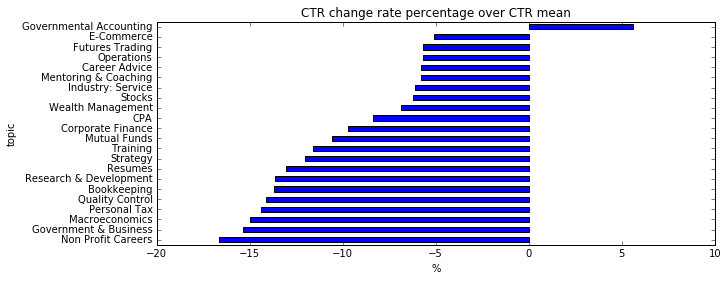

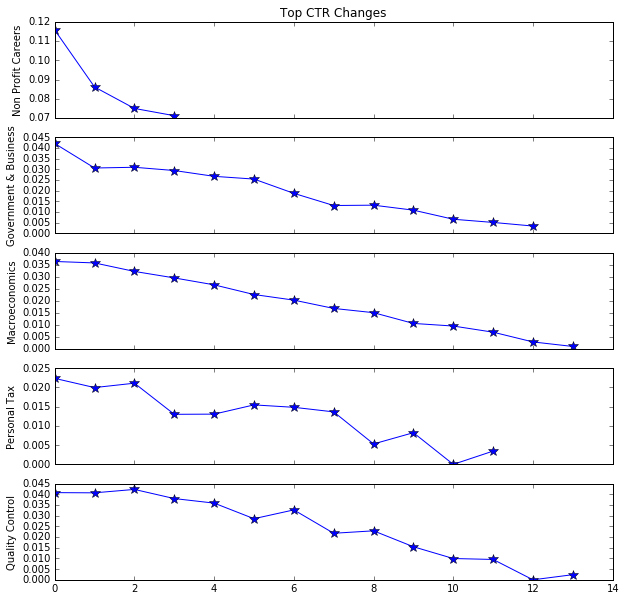

In [113]:
groups=check_overall(SumBy.topic)

### Results and Discussion
- the first bar chart shows the percentage of CTR change rate over the mean CTR, and it filters out anything less than 5%, which we consider insignificant.
- the trend chart picks the top 5 topics with decreasing trends, we can see the CTR is steadily reducing for those topics
- further investigation reveals that CTR of all topics, except one, actually have decreasing trend, so the overall click probability are all decreasing across topics.
- even for the topic of **governmental accounting**, the positive CTR change rate is due to a most recent spike, see below, this could be due to a particular event which creates an outlier
- using the same slope statistic on the count of link sent (n_send) and link clicked (n_click), we found both numbers have increasing trend for some topics, see second trend chart below for **CPA** send count. This indicates that although click can increase with more links sent out, the overall effectiveness is still reducing.


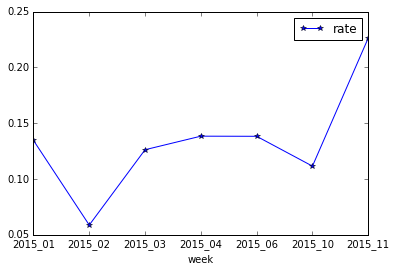

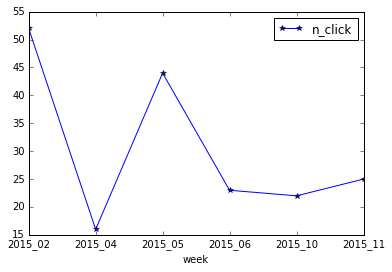

In [131]:
groups.get_group('Governmental Accounting').plot(kind='line', x='week', y='rate', style='*-')
groups.get_group('CPA').plot(kind='line', x='week', y='n_send', style='*-')

### Evaluate overall trend by article type

running the query ...

        select c.n_click, s.n_send, c.n_click/(1.0*s.n_send) as rate, s.week, s.type 
        from (
        select count(*) as n_send, e.week_num as week, t.name as type from 
        email_content e left join articles a on e.article_id = a.article_id
        join types t on t.type_id = a.type_id
        group by e.week_num, t.name
    ) s left join (
        select count(*) as n_click, e.week_num as week, t.name as type from 
        clicks e left join articles a on e.article_id = a.article_id
        join types t on t.type_id = a.type_id
        group by e.week_num, t.name
    ) c
        on s.week = c.week and s.type=c.type    
    


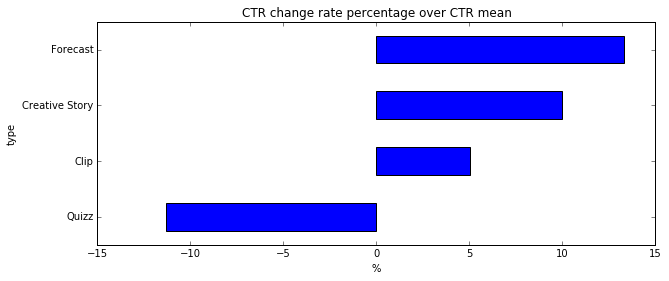

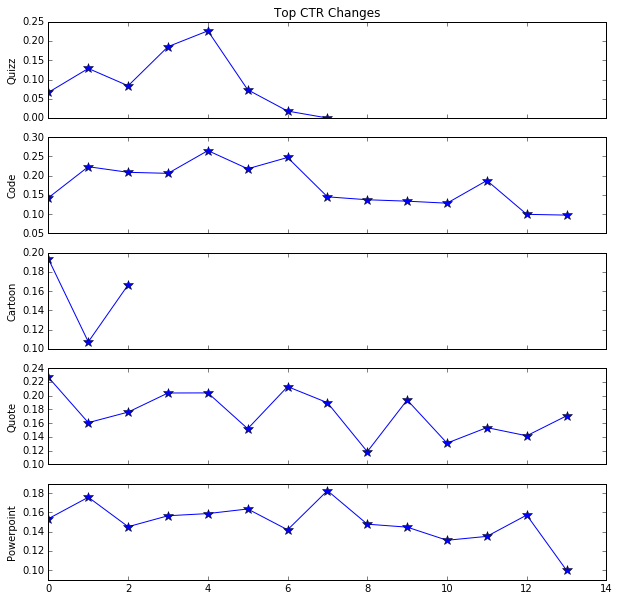

In [135]:
groups = check_overall(SumBy.type)

### Results and Discussion
- for article type, we only see 4 types with significant CTR change rate
- the trend charts show top 5 types with decreasing trend, and only **Quizz** is significant, due to most recent drop, while the rest of show insignificant decreasing pattern
- **Forecast** has a big increasing rate, upon close look (first trend chart below), the most recent week sees a spike on the links sent out, which becomes an outlier and bias the model
- similar for **Creative Story**, we can see that on week _11_ only 36 links are sent while 19 of them is clicked, this increases one CTR towards the end (second trend chart below) significantly, and increases the slope
- in general, with article type we don't see much significant CTR change, notice that there are only 49 types compare with 100+ topics, so by less granularity the change patter becomes unobvious. Furthermore, it is less likely that reader bases their preference on the type, rather than topic.

     n_click  n_send      rate     week            type
53      24.0     119  0.201681  2015_02  Creative Story
99      79.0     411  0.192214  2015_03  Creative Story
145    157.0    1290  0.121705  2015_04  Creative Story
192      8.0     117  0.068376  2015_05  Creative Story
239     94.0     920  0.102174  2015_06  Creative Story
330     63.0     662  0.095166  2015_08  Creative Story
470     19.0      36  0.527778  2015_11  Creative Story
517    135.0     373  0.361930  2015_12  Creative Story
563    178.0     773  0.230272  2015_13  Creative Story


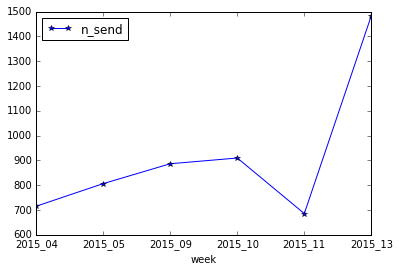

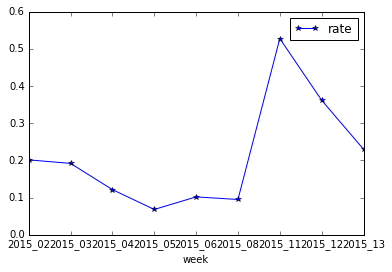

In [149]:
groups.get_group('Forecast').plot(kind='line', x='week', y='n_send', style='*-')
print(groups.get_group('Creative Story'))#.plot(kind='line', x='week', y='n_send', style='*-')
groups.get_group('Creative Story').plot(kind='line', x='week', y='rate', style='*-')

# 2. Individual user investigation

- analysis of article type above indicates that the overall approach, without distinguishing individual, may not be as effective to evaluate the overall email campaign. Since users are different in preference of article.
- in this section, we evaluate the CTR for individual, based on email each user receives
- each email generate two vectors for send and click count, then we again fit a linear model to check the change rate for each topic/type
- below two queries show the number of emails per week, and average email user received over the period. We can see that the variance of emails user receives is very small.

In [134]:
# check how many emails per user per week
sql = '''select count(*) as n_email, user_id, week_num from 
        (select distinct user_id,email_id,week_num from email_content) 
        group by user_id, week_num
'''
run_sql(sql).groupby('week_num').size()

week_num
2015_01    18841
2015_02    20000
2015_03    20000
2015_04    20000
2015_05    20000
2015_06    20000
2015_07    20000
2015_08    20000
2015_09    20000
2015_10    20000
2015_11    20000
2015_12    20000
2015_13    20000
2015_14    19935
dtype: int64

In [150]:
# check how many emails per user (on average) in all weeks
sql = '''select count(*) as n_email, user_id from 
        (select distinct user_id,email_id from email_content) 
        group by user_id
'''
run_sql(sql).describe()

,n_email,user_id
count,20000.000000,20000.000000
mean,52.921800,10000.500000
std,2.314898,5773.647028
min,44.000000,1.000000
25%,51.000000,5000.750000
50%,53.000000,10000.500000
75%,55.000000,15000.250000
max,61.000000,20000.000000


### Define functions
- SQL query joins click and email tables, and retrieve all email info for a given user
- manual processing to generate feature vector for send and click count (this step should be improved)
- charts example are given to indicate CTR change in topic/type for two individuals

In [83]:
def moving_average(a, n):
    '''
    Calculate moving average for array with NaN
    '''
    i, ret = 0, []
    while i+n<len(a):
        if np.isnan(a[i:i+n]).sum()==n:
            ret.append(np.nan)
        else:
            ret.append(np.nanmean(a[i:i+n]))
        i += 1
    return np.array(ret)


def check_user(user_id, sumBy):
    '''
    Data analysis main process
    1. for given user, get email summary for article topic/type
    2. evaluate CTR change rate for each topic/type overall the emails
    3. generate plots
    '''
    # generate SQL based on input parameters
    users = run_sql('select * from users').set_index('user_id')
    print('start checking article %s for user <%s> ...' %(sumBy.name, users.email[user_id]))
    col, tab, bheight = ('type_id','types',10) if sumBy==SumBy.type else ('topic_id','topics',15)
    sql = '''
        select e.*, c.click_time, c.status as status, c.bsize, a.%s as %s from
        (select * from email_content where user_id=%d) e left join clicks c 
        on e.user_id=c.user_id and e.article_id=c.article_id
        join articles a on a.article_id=e.article_id        
    ''' %(col, col, user_id)
    
    # run the query and group the dataframe by email
    dim = run_sql('select max(%s)+1 from %s' %(col, tab)).ix[0].values[0]    
    print('running query (may take a little while) ...')
    emails = run_sql(sql, True).groupby('email_id')
    n_email = len(emails)
    m_click, m_send = np.zeros((n_email,dim)), np.zeros((n_email,dim))

    # summarize counts of clicks and send for article topic/type
    print('summarizing %d emails ...' %n_email)
    i=0
    for eid, email in emails:
        # check send count
        vc_send = email[col].value_counts()
        for cid in vc_send.index:
            m_send[i,cid] = vc_send[cid]
        # check click count
        vc_click = email[email.status>0][col].value_counts()
        for cid in vc_click.index:
            m_click[i,cid] = vc_click[cid]
        # continue with next email
        i+=1
    
    # get slope of click rate for each topic/type
    print('evaluating click rate change rate for article %s ...' %sumBy.name)
    rate, slope = m_click/m_send, []
    for j in range(rate.shape[1]):
        y = moving_average(rate[:,j],5)
        pick = ~np.isnan(y)
        if sum(pick)<2:
            slope.append(np.nan)
        else:
            slope.append(np.polyfit(np.arange(len(y))[pick],y[pick],1)[0])
    
    # generate plots
    cat = run_sql('select * from %s' %tab)    
    cat['slope'] = pd.Series(slope[1:])
    cat.set_index('name', inplace=True)
    cat = cat[cat.slope.abs()>0].sort_values(by=['slope'])
    cat.plot(kind='barh',y='slope',figsize=(10,bheight))
    plt.ylabel(sumBy.name)
    plt.title('CTR change rate of article %s of user: %s' %(sumBy.name, users.email[user_id]))
    # chart row click rate for the top changers
    n_top = 5
    f, axarr = plt.subplots(n_top, sharex=True, figsize=(10, 2*n_top))
    axarr[0].set_title('Top CTR Changes')    
    for i in range(5):
        axarr[i].plot(rate[:, cat[col].ix[-i-1]], '*-', ms=10)
        axarr[i].set_ylabel(cat.index[-i-1])
    plt.tick_params(labelsize=10)

### Example - check article type trend for user 318

start checking article type for user <kevin.rossi@fhcdz.com> ...
running query (may take a little while) ...

        select e.*, c.click_time, c.status as status, c.bsize, a.type_id as type_id from
        (select * from email_content where user_id=318) e left join clicks c 
        on e.user_id=c.user_id and e.article_id=c.article_id
        join articles a on a.article_id=e.article_id        
    
summarizing 52 emails ...
evaluating click rate change rate for article type ...


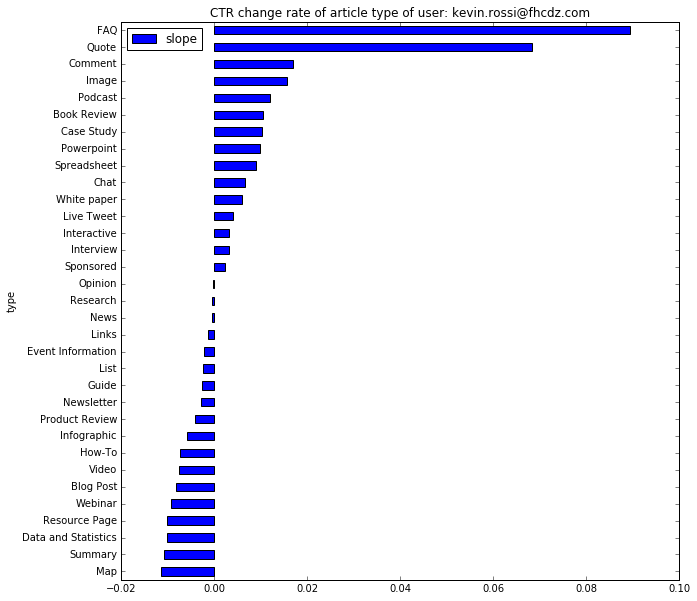

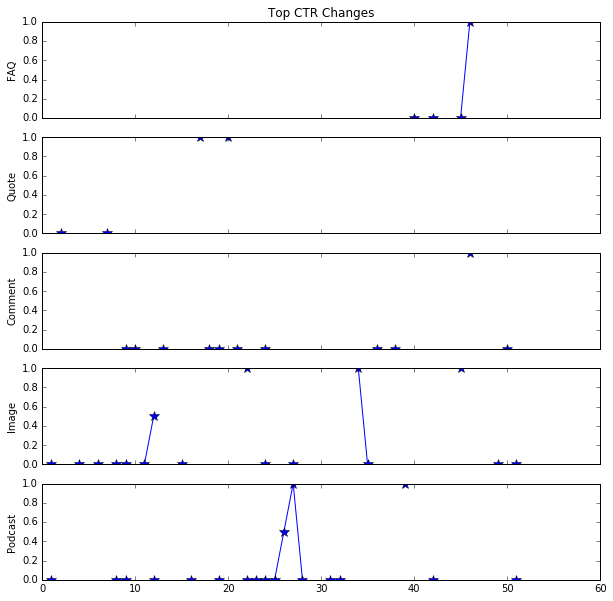

In [84]:
check_user(318, SumBy.type)

### Example - check article topic trend for user 813 

start checking article topic for user <kimberly.ferris@pnhka.com> ...
running query (may take a little while) ...

        select e.*, c.click_time, c.status as status, c.bsize, a.topic_id as topic_id from
        (select * from email_content where user_id=813) e left join clicks c 
        on e.user_id=c.user_id and e.article_id=c.article_id
        join articles a on a.article_id=e.article_id        
    
summarizing 51 emails ...
evaluating click rate change rate for article topic ...


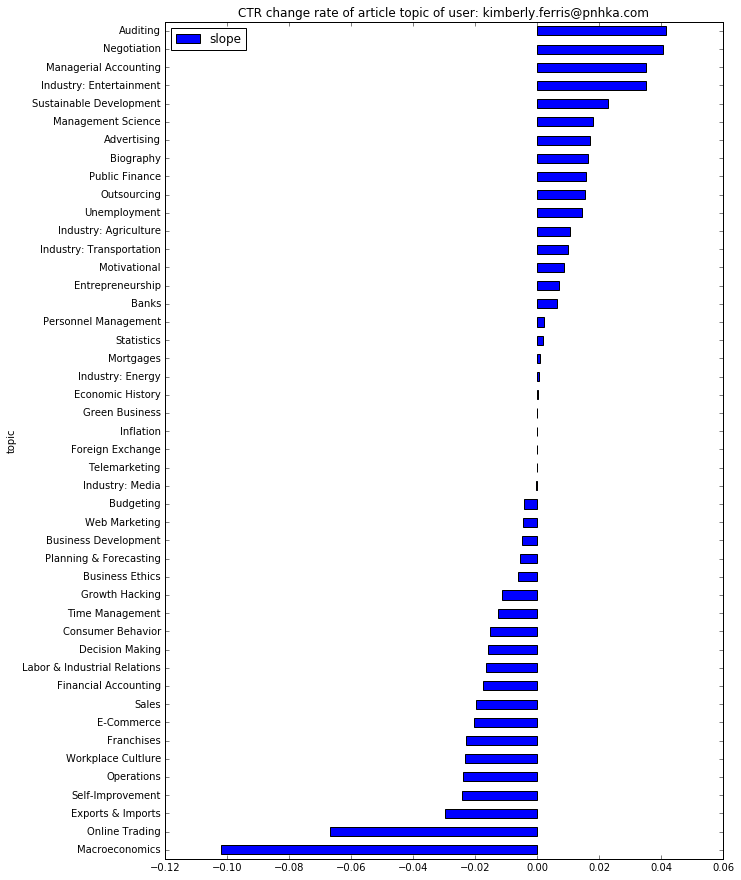

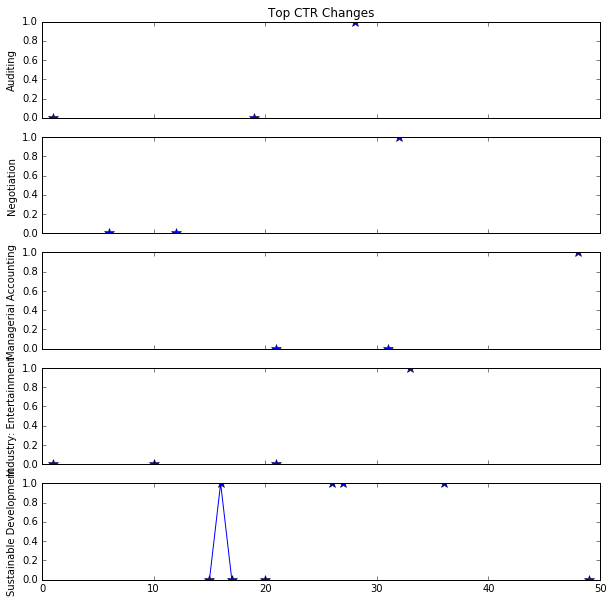

In [85]:
check_user(813, SumBy.topic)

### Results and Discussion
- trend charts above show raw CTR for top 5 article topic/type
- due to the sporadic distributions of topic/type, the actual data points to evaluate CTR change are limited, it is desired to have more data with longer period such that all topic/type can be accurately evaluated.
- both persons have topics/types with significant increasing and creasing trend, this gives good indicator on personal reference, and we know what the user likes or dislikes
- by running **check_user** for given ID and category, we are able to answer the question that how click probability of a link changes for a user

# Summary

- overall the email effectiveness is decreasing based on article topic, more links would give more clicks in short term, but at some point, user could have reading fatigue.
- example from individual analysis reveals more significant CTR change
- for long term, it is necessary to evaluate preference for each user, and tailor the email based on their preference 

# Future Work
- not all user are evaluated, a MapReduce job would be capable to the job
- redo the analysis with combined article type and topic for finer granularity


In [151]:
conn.close()